In [38]:
%load_ext autoreload
%autoreload 2

# load environment variables
import os
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")

from sqlalchemy import create_engine

from src.functions.io import ModuleFileReader, save_to_figures
from src import queries
scripts = ModuleFileReader(queries)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
engine = create_engine(os.environ.get("DATABASE_URL"))

# Horror Analysis

Horror has the best profitability of any Hollywood genre. Why is this?

## First, let's look at some basic things comparing Horror to Non-Horror

In [3]:
films = pd.read_sql_query(scripts.read("films_join_hot_genres.sql"), engine)
films = films.set_index(pd.DatetimeIndex(films.released))
films = films[films.index.year > 2009]
films.drop("released", axis=1, inplace=True)
films.head()

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2018-01-05,1,Insidious: The Last Key,PG-13,0,0,0,0,5.7,32.0,49.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,5,The Commuter,PG-13,0,0,0,0,6.3,57.0,56.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,6,Proud Mary,R,0,0,0,0,4.9,28.0,35.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,8,Freak Show,N/A,0,0,0,0,6.3,51.0,54.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-19,12,12 Strong,R,0,0,0,0,6.6,52.0,54.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
horror = films[films.horror == 1]
non_horror = films[films.horror != 1]

In [5]:
round(len(horror)/len(films), 3)

0.1

- Approximately 10% of all films were horror between 2010-2018

Lets get a timeseries view of all horror releases

## Time Series

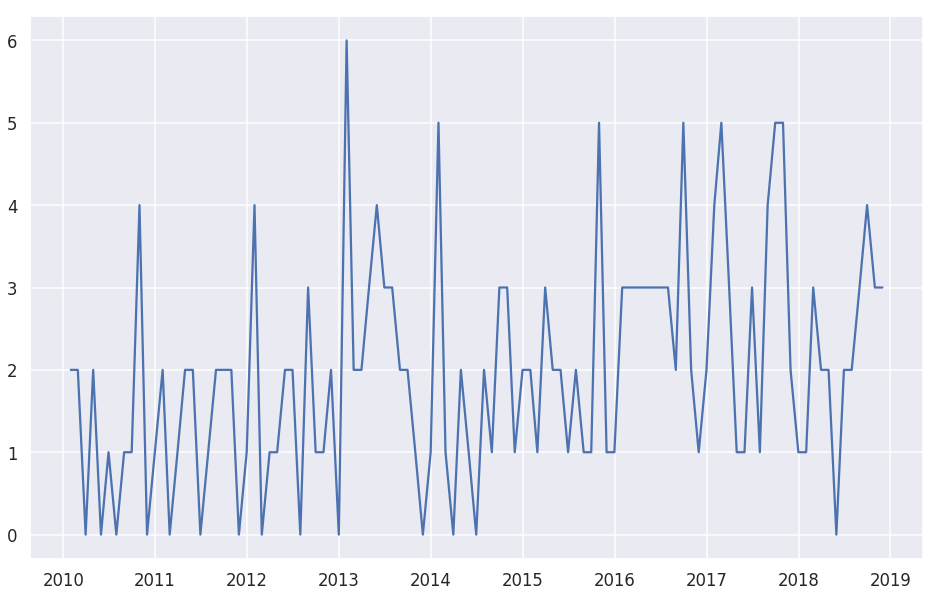

In [6]:
horror_timeline = horror.resample('M').count().id
plt.figure(figsize=(16,10))
plt.plot(horror_timeline.index, horror_timeline.values)
plt.savefig(save_to_figures("horror_yearmonth_releases.png"))

- It does appear that there has been a shift towards more horror releases in recent years

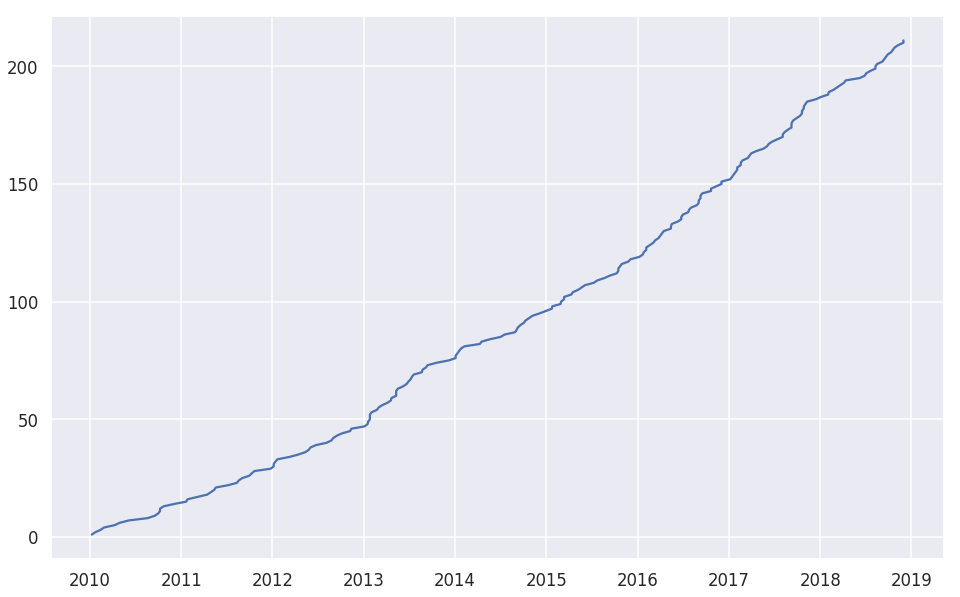

In [7]:
horror_cumulative = horror.sort_index().cumsum().horror
plt.figure(figsize=(16,10))
plt.plot(horror_cumulative.index, horror_cumulative.values)
plt.savefig(save_to_figures("horror_cumulative_releases.png"))

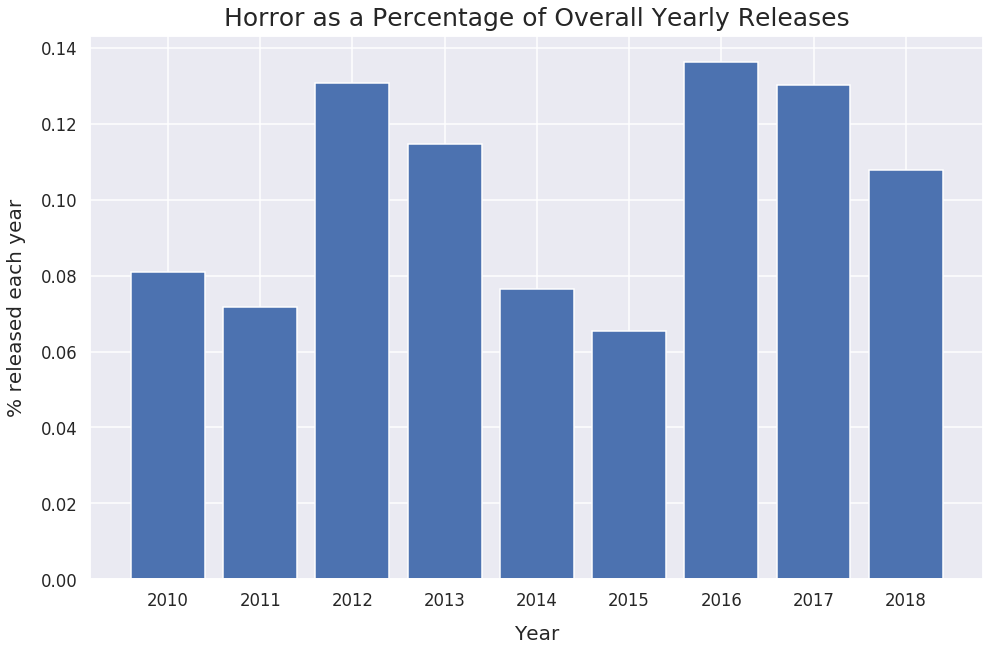

In [8]:
plt.figure(figsize=(16,10))
horror_yearly = horror.groupby(horror.index.year).count()['title']
total_yearly = films.groupby(films.index.year).count()['title']
normalized = horror_yearly/total_yearly
plt.bar(normalized.index, normalized.values)
plt.xticks(horror.index.year.unique())
plt.ylabel("% released each year", fontsize=20, labelpad=15)
plt.xlabel("Year", fontsize=20, labelpad=15)
plt.title("Horror as a Percentage of Overall Yearly Releases", fontsize=25, pad=10)

plt.savefig(save_to_figures("horror_pct_released.png"))
plt.show()

In [9]:
normalized.mean()

0.10157361501937008

## Comparing horror and non-horror ROIs

In [10]:
genre_financials = pd.read_sql_query(scripts.read("genre_financials.sql"), engine)
film_financials = pd.read_sql_query(scripts.read("film_financials.sql"), engine)

horror_ids = genre_financials[genre_financials.genre == 'Horror'].id.values
film_financials['horror'] = film_financials['id'].apply(lambda x: 1 if x in horror_ids else 0)

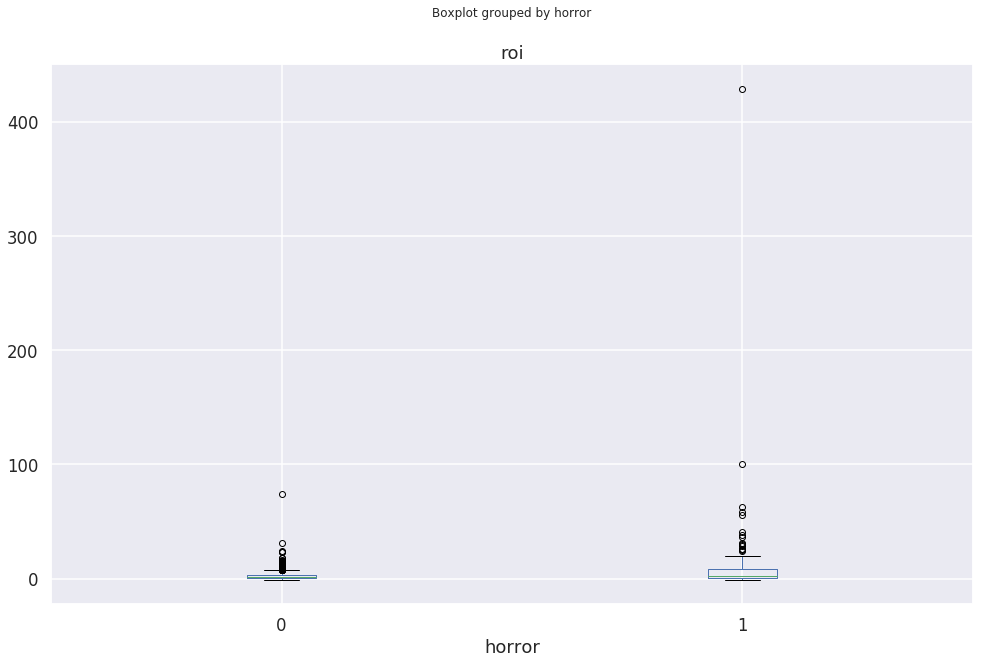

In [11]:
film_financials.boxplot("roi", by='horror', figsize=(16,10))

With outliers removed:

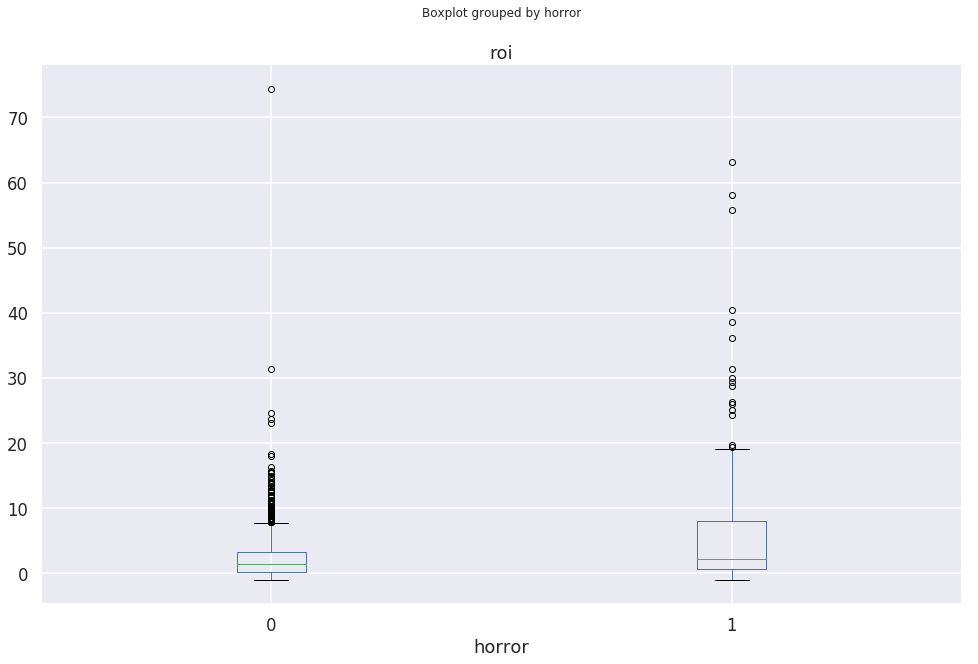

In [12]:
film_financials[film_financials['roi'] < 100].boxplot("roi", by='horror', figsize=(16,10))

- Kind of hard to discern the difference in medians here but the interquartile range for horror film ROIs is twice as big

In [13]:
films_no_outliers = films[films.roi < 100]

In [14]:
genres = films.columns[17:]

mean_genre_rois = dict()
median_genre_rois = dict()

for g in genres:
    genre_films = films_no_outliers[films_no_outliers[g] == 1]
    mean_genre_rois[g] = genre_films.roi.mean()
    median_genre_rois[g] = genre_films.roi.median()
    
mean_genre_rois = pd.Series(mean_genre_rois).sort_values(ascending=True)
median_genre_rois = pd.Series(median_genre_rois).sort_values(ascending=True)

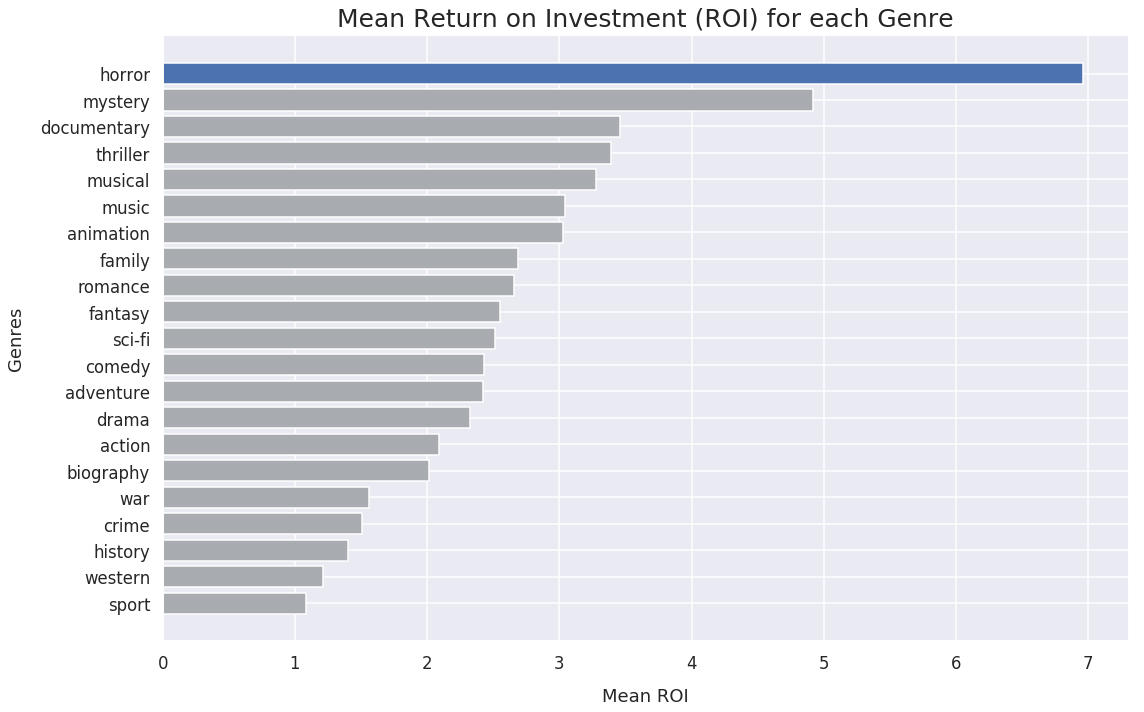

In [15]:
plt.figure(figsize=(16,10))
for g in mean_genre_rois.index:
    if g == 'horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, mean_genre_rois[g], color=c)
# for g in mean_genre_rois.index:
#     if g == 'horror':
#         c ='#1212a5'
#     else: c = '#888889'
#     plt.barh(g, median_genre_rois[g], color=c)

# plt.xticks(rotation=45)
plt.xlabel("Mean ROI", labelpad=15)
plt.ylabel("Genres", labelpad=15)
plt.title('Mean Return on Investment (ROI) for each Genre', fontsize=25, pad=10)
plt.tight_layout()
plt.savefig(save_to_figures("genre_mean_roi.png"))

In [16]:
horror.describe()

,id,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,budget,domestic_gross,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,207.000000,199.000000,1.700000e+02,1.750000e+02,...,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.0,211.000000,211.0,211.000000
mean,1051.379147,6.715640,0.838863,0.033175,0.009479,5.787678,49.454106,49.030151,2.151118e+07,3.357074e+07,...,0.208531,0.014218,0.161137,0.009479,0.071090,0.023697,0.0,0.009479,0.0,0.004739
std,671.909276,16.310227,8.637824,0.265184,0.097126,0.925943,28.442184,17.151114,2.850081e+07,4.435691e+07,...,0.407224,0.118670,0.368532,0.097126,0.257586,0.152464,0.0,0.097126,0.0,0.068843
min,1.000000,0.000000,0.000000,0.000000,0.000000,3.200000,0.000000,13.000000,1.000000e+05,7.420000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,460.500000,0.000000,0.000000,0.000000,0.000000,5.100000,23.000000,35.500000,5.000000e+06,2.170936e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,1005.000000,0.000000,0.000000,0.000000,0.000000,5.800000,48.000000,48.000000,1.080000e+07,1.907529e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
75%,1609.000000,6.000000,0.000000,0.000000,0.000000,6.400000,73.000000,62.000000,3.000000e+07,4.538504e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
max,2327.000000,181.000000,122.000000,3.000000,1.000000,8.100000,100.000000,87.000000,1.900000e+08,3.274817e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000


In [17]:
non_horror.describe()

,id,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,budget,domestic_gross,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
count,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1904.000000,1717.000000,1697.000000,1.242000e+03,1.526000e+03,...,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000
mean,1148.287736,15.083857,5.059748,0.176625,0.075472,6.491702,58.895748,56.563936,4.749100e+07,4.730125e+07,...,0.107442,0.110587,0.112683,0.067610,0.193396,0.104822,0.031447,0.012055,0.050314,0.023585
std,666.430839,33.970734,19.159464,0.736877,0.462054,0.974846,27.855692,17.914487,5.483520e+07,8.431314e+07,...,0.309756,0.313702,0.316288,0.251141,0.395064,0.306404,0.174567,0.109158,0.218650,0.151792
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000,1.000000,1.000000e+00,4.220000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,572.750000,0.000000,0.000000,0.000000,0.000000,5.900000,36.000000,44.000000,1.052500e+07,1.365782e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1143.500000,2.000000,0.000000,0.000000,0.000000,6.500000,64.000000,57.000000,2.600000e+07,1.495904e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1711.500000,13.000000,0.000000,0.000000,0.000000,7.200000,84.000000,70.000000,6.000000e+07,5.578969e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2360.000000,326.000000,235.000000,10.000000,7.000000,9.400000,100.000000,100.000000,4.000000e+08,9.366622e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Looking at the difference in both the mean and median values for horror/non-horror ROIs there is a difference.
- Big difference in means: 10.37x ROI for horror compared to 2.29x for non-horror.
- Medians are less pronounced, but still a difference: 2.26x horror vs 1.40x non-horror.
- **Is the difference in means between horror and non-horror statistically significant?**

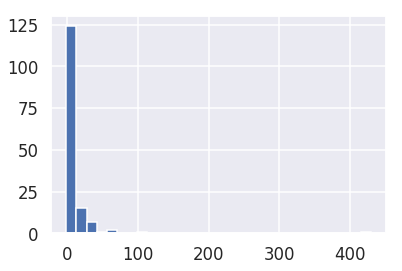

In [18]:
horror.roi.hist(bins=30)

removing outlier film:

In [19]:
horror[horror.roi > 100]

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2015-07-10,1005,The Gallows,R,0,0,0,0,4.2,15.0,30.0,...,0,0,0,0,0,0,0,0,0,0
2012-01-06,1740,The Devil Inside,R,3,0,0,0,4.2,6.0,18.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
horror_no_outliers = horror[horror.roi < 100]

In [21]:
# lets just get rid of the gallows
no_gallows = horror[horror.id != 1005]

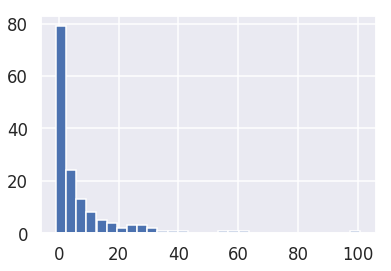

In [22]:
no_gallows.roi.hist(bins=30)

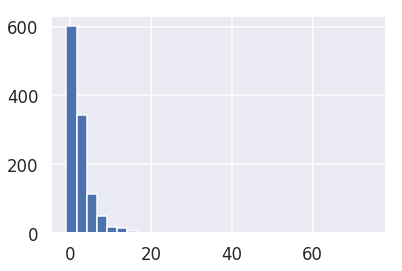

In [23]:
non_horror.roi.hist(bins=30)

- Comparing no_gallows and non_horror histograms we can see that many more horror films fall into the 10-20 ROI range than non horror

## Hypothesis Tests

Betty also mentioned liklihood ratio test, look into that later you momo

### Welch's T-Test (On raw data)

**H0**: The difference between the horror and non-horror sample means is a result of chance, there is no real difference between the populations<br/>
**HA**: Horror has a higher ROI than non-horror (Horror Mean - Non Horror Mean > 0)

We'll conduct this test at a significance level of 0.05 (5% chance of a type I error). This is a one-tailed T test.

In [24]:
# put rois for horror and non horror into arrays
horror_array = np.array(horror_no_outliers[horror_no_outliers.roi.notnull()].roi)
non_horror_array = np.array(non_horror[non_horror.roi.notnull()].roi)

n_horror = len(horror_array)
n_non_horror = len(non_horror_array)
print('Horror samples: {}\nNon Horror samples: {}'.format(n_horror, n_non_horror))

Horror samples: 149
Non Horror samples: 1156


In [25]:
horror_mean = horror_array.mean()
non_horror_mean = non_horror_array.mean()
print('Horror mean: {}\nNon Horror mean: {}'.format(horror_mean, non_horror_mean))

Horror mean: 6.95766668491648
Non Horror mean: 2.327459666376172


In [26]:
horror_mean - non_horror_mean

4.6302070185403075

In [27]:
horror_var = horror_array.var(ddof=1) # gives the biased variance unless specified by ddof
# horror_var2 = np.sum(np.square(horror_array - horror_mean))/(len(horror_array) - 1)
non_horror_var = non_horror_array.var(ddof=1)

In [28]:
horror_var

130.1521100056284

In [29]:
# calculate t statistic
se_horror = (horror_var/n_horror) # Standard error
se_non_horror = (non_horror_var/n_non_horror)
t = (horror_mean - non_horror_mean)/(se_horror + se_non_horror)
t

5.223308498013655

In [30]:
# calculate df
df = (np.square(se_horror + se_non_horror))/((np.square(se_horror)/(n_horror - 1)) + 
                                             (np.square(se_non_horror)/(n_non_horror - 1))) 
df

152.41547530117217

In [31]:
#p = 1 - stats.t.cdf(t,df=df)

In [32]:
from scipy import stats

In [33]:
p = (1 - stats.t.cdf(t,df=df))

In [34]:
p

2.8411101249403714e-07

In [35]:
'{:.20f}'.format(p)

'0.00000028411101249404'

Since p is less than 0.05, we can reject our null hypothesis in favour of the alternate hypothesis that horror films do better ROIs than non-horror films.

## Visualizing the T test

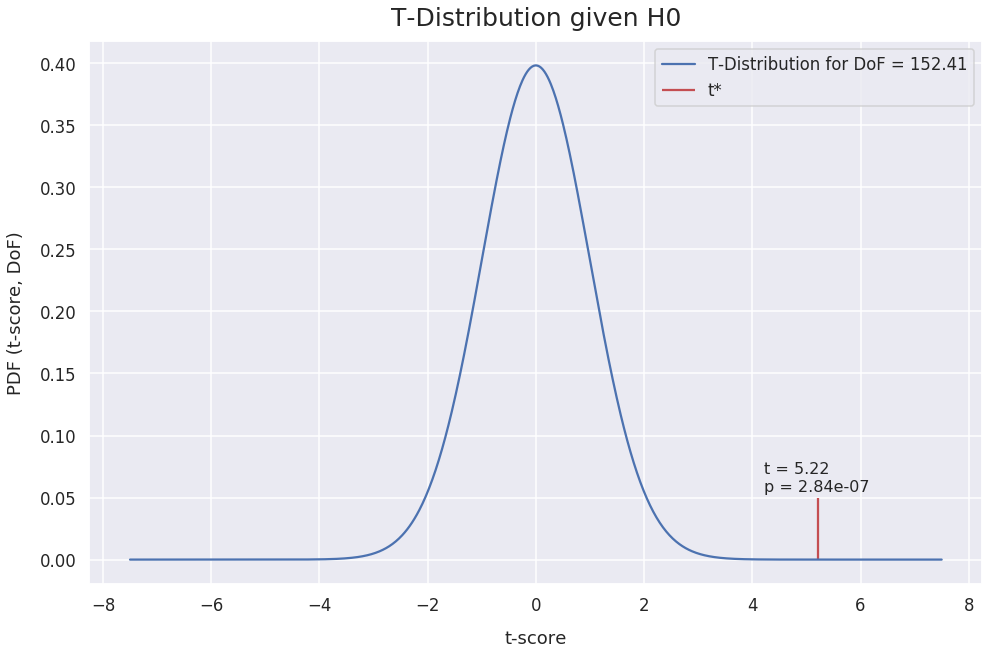

In [36]:
plt.figure(figsize=(16,10))

xs = np.linspace(-7.5, 7.5, num=1000)
ys = stats.t.pdf(xs, df)

plt.plot(xs, ys, label='T-Distribution for DoF = 152.41')
plt.vlines([t], 0.0, 0.05, colors='r', label='t*')
plt.annotate("t = 5.22\np = 2.84e-07", (t - 1, 0.055), fontsize=16)
plt.xlabel("t-score", labelpad=15)
plt.ylabel("PDF (t-score, DoF)", labelpad=15)
plt.title("T-Distribution given H0", pad=15, fontsize=25)
plt.legend()

plt.savefig(save_to_figures("t_test.png"))

## Confidence Intervals for Horror Mean

In [41]:
from src.functions.stats import mean_confidence_interval

In [40]:
mean_confidence_interval(horror_array)

(6.95766668491648, 5.110754127930825, 8.804579241902134)

## Why might this be?

The ROI is calculated by (total gross - budget)/budget. Let's investigate both budgets and total grosses to see what's going on

## Budget

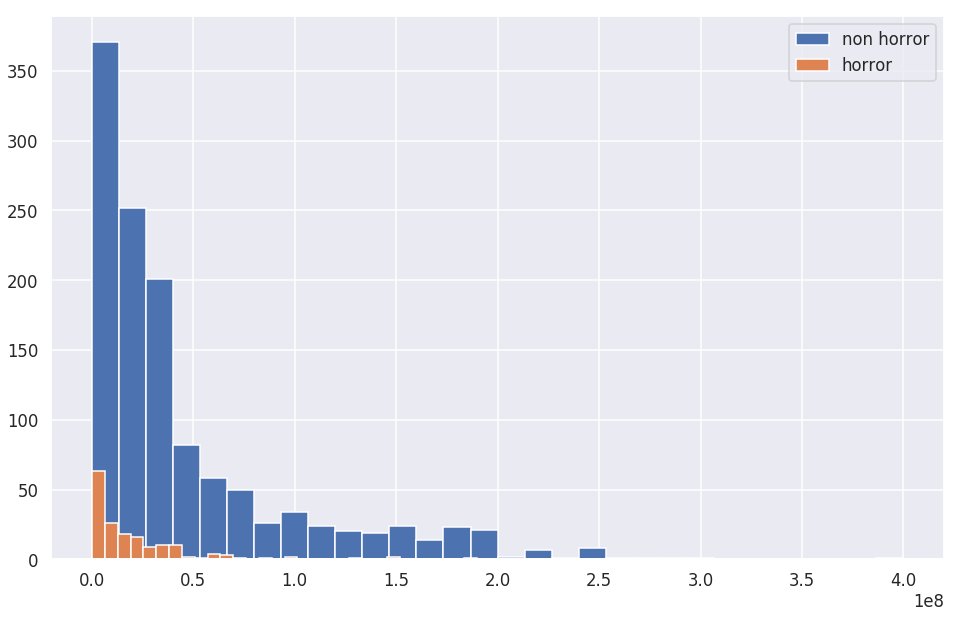

In [42]:
plt.figure(figsize=(16,10))
non_horror.budget.hist(bins=30, label='non horror')
horror.budget.hist(bins=30, label='horror')
plt.legend()

In [43]:
genre_budgets = dict()
genre_grosses = dict()
for g in genres:
    genre_films = films[films[g] == 1]
    genre_budgets[g] = genre_films.budget.median()
    genre_grosses[g] = genre_films.total_gross.median()
median_budgets = pd.Series(genre_budgets)
median_grosses = pd.Series(genre_grosses)

In [44]:
median_budgets = median_budgets.sort_values(ascending=True)
median_grosses = median_grosses.sort_values(ascending=True)

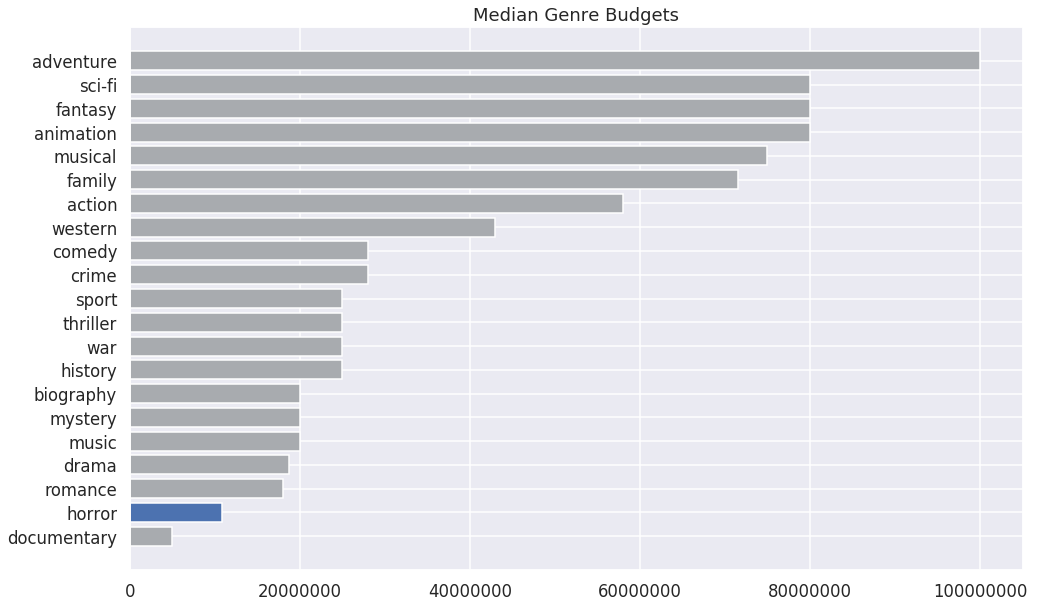

In [45]:
plt.figure(figsize=(16,10))
for g in median_budgets.index:
    if g == 'horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, median_budgets[g], color=c)
# plt.xticks(rotation=45)
plt.title('Median Genre Budgets')
plt.ticklabel_format(axis='x', style='plain')

- Horror has the second lowest budget of all genres! The ROI can be explained by the fact that they're cheap to make

<Figure size 1152x432 with 0 Axes>

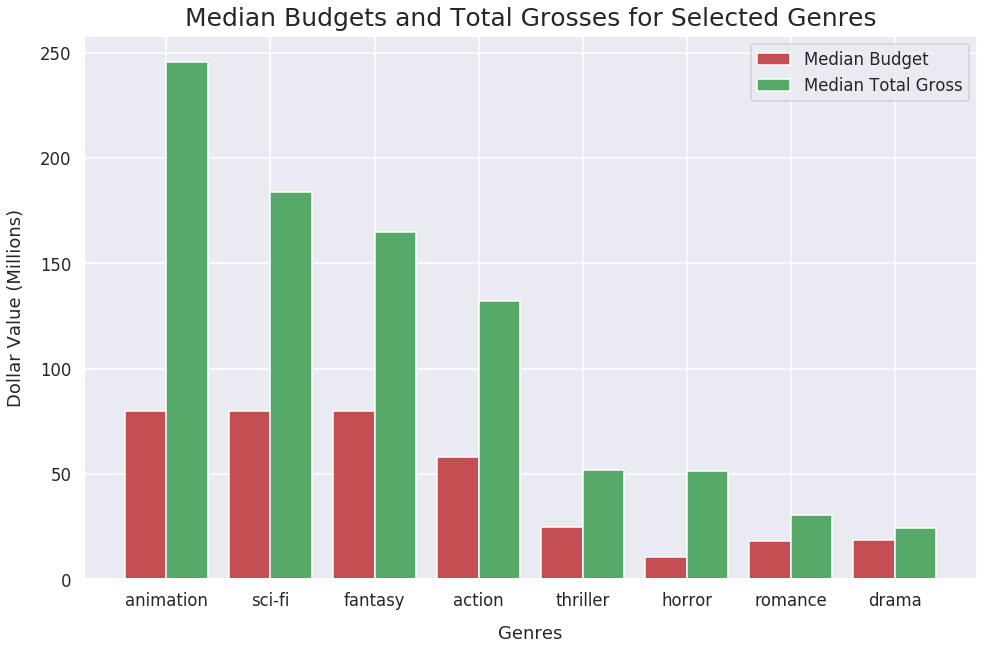

In [47]:
example_genres = ['animation', 'sci-fi', 'fantasy', 'action', 'thriller', 'horror', 'romance', 'drama']
ind = np.arange(len(example_genres))
width = 0.4

plt.figure(figsize=(16,6))
fig, ax = plt.subplots(figsize=(16,10))

p1 = ax.bar(ind,
        median_budgets[example_genres]/1000000,
        width=width,
        color='r',
        label='Median Budget')
p2 = ax.bar(ind + width,
        median_grosses[example_genres]/1000000,
        width=width,
        color='g',
        label='Median Total Gross')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(example_genres)
plt.title('Median Budgets and Total Grosses for Selected Genres', pad=10, fontsize=25)
ax.legend()
ax.set_ylabel('Dollar Value (Millions)', labelpad=15)
ax.set_xlabel('Genres', labelpad=15)

plt.savefig(save_to_figures("genre_median_budgets_grosses.png"))

In [48]:
import matplotlib.ticker as mtick

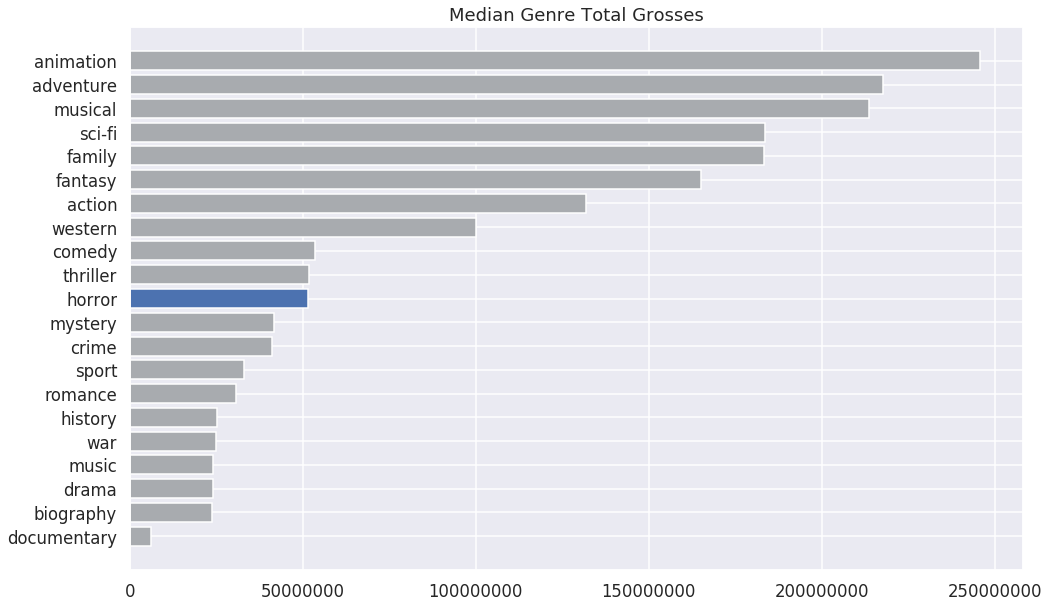

In [49]:
plt.figure(figsize=(16,10))
for g in median_grosses.index:
    if g == 'horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, median_grosses[g], color=c)
#plt.xticks(rotation=45)
plt.title('Median Genre Total Grosses')
plt.ticklabel_format(axis='x', style='plain')

## Deeper Dive into Budgets

Why are horror budgets cheaper? Let's try to investigate

### Horror Actors, Directors, Producers, etc

- Do horror films have fewer key personnel working on them?
- Do horror films employ lower-tier key personnel (who command lower pays?)? i.e. No big A-list celebrities commanding higher salaries, etc.



[Text(0, 0, 'total_persons'),
 Text(0, 0, 'num_actors'),
 Text(0, 0, 'num_directors'),
 Text(0, 0, 'num_producers'),
 Text(0, 0, 'num_writers'),
 Text(0, 0, 'num_editors'),
 Text(0, 0, 'num_screenwriters'),
 Text(0, 0, 'num_story'),
 Text(0, 0, 'num_composers'),
 Text(0, 0, 'num_narrators')]

<Figure size 1152x432 with 0 Axes>

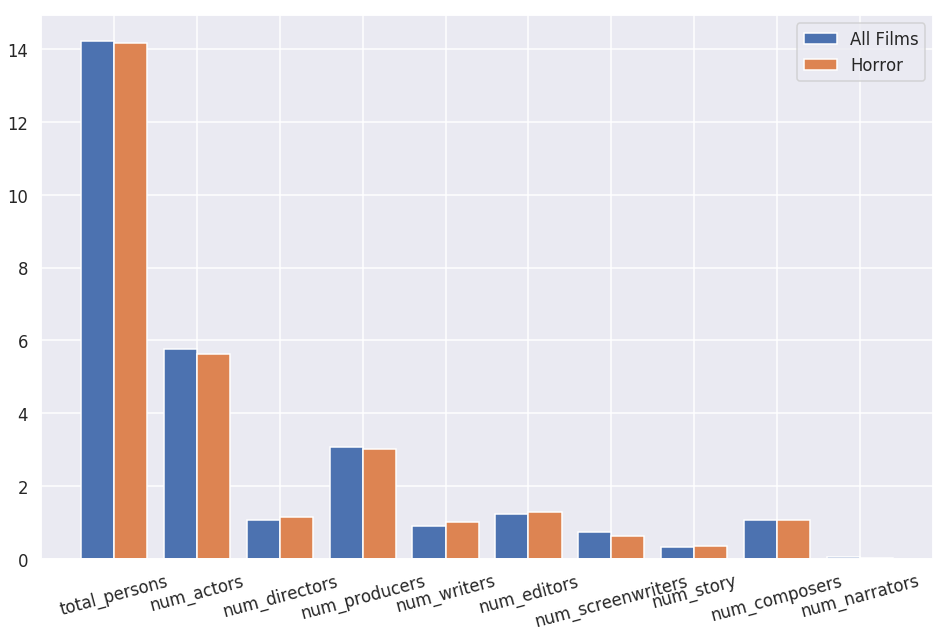

In [50]:
persons_per_role = pd.read_sql_query(scripts.read("persons_per_role.sql"), engine)
horror_persons_per_role = persons_per_role[persons_per_role.id.isin(horror_ids)]

ind = np.arange(len(persons_per_role.mean()[1:].index))
width = 0.4

plt.figure(figsize=(16,6))
fig, ax = plt.subplots(figsize=(16,10))

p1 = ax.bar(ind,
        persons_per_role.mean()[1:].values,
        width = width)
p2 = ax.bar(ind + width,
        horror_persons_per_role.mean()[1:].values,
        width = width)

ax.legend((p1[0], p2[0]), ('All Films', 'Horror'))

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(persons_per_role.mean()[1:].index, rotation=15)


- Horror films are in line with total averages when it comes to # of key persons

- Do horror films have lower-budget actors? Are they in less roles overall?

## They're in less roles overall

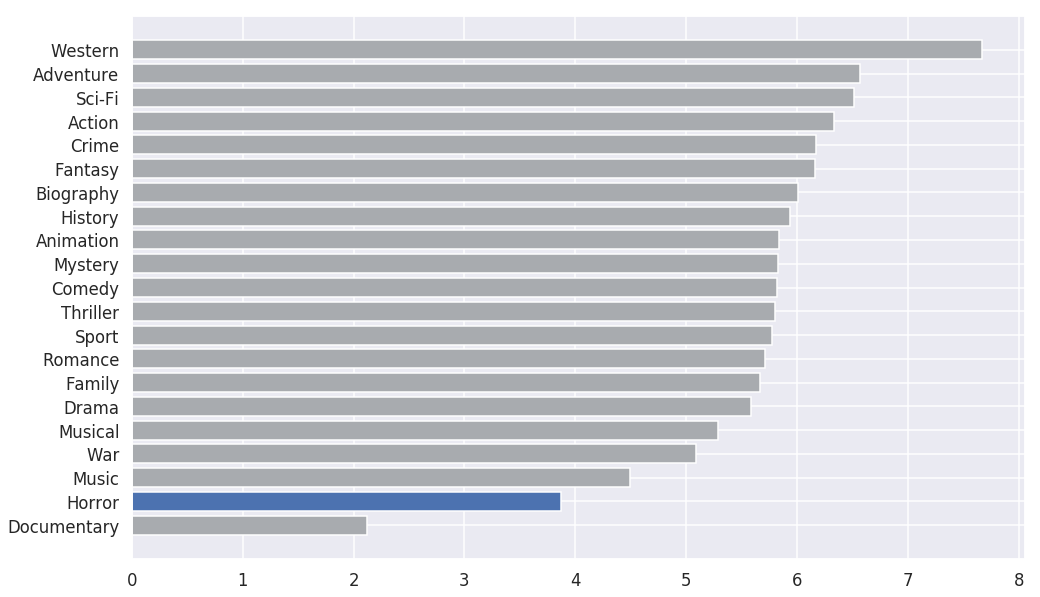

In [51]:
genre_actors_metrics= pd.read_sql_query(scripts.read("genre_actors_metrics.sql"), engine).set_index('genre')
genre_actors_metrics.drop(labels=['N/A', 'Short', 'Film-Noir'], axis=0, inplace=True)

genre_actors_n_roles = genre_actors_metrics.avg_film_count.sort_values(ascending=True)

plt.figure(figsize=(16,10))
for g in genre_actors_n_roles.index:
    if g == 'Horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, genre_actors_n_roles[g], color=c)

plt.xticks(rotation=0)
plt.show()

# ***Can compare infinity war and the nun***

In [52]:
genre_actors_metrics

,avg_film_count,avg_budget,avg_roi,avg_meta,avg_imdb,avg_tomatoes
genre,,,,,,
Sport,5.771242,5.203585e+07,1.907234,56.819246,6.722122,62.310109
Biography,6.007867,4.286707e+07,2.264444,58.254623,6.701790,61.635468
Thriller,5.806114,4.853932e+07,3.340133,53.715851,6.362157,54.669475
Romance,5.707627,4.405112e+07,2.486657,55.447920,6.391109,56.223161
Adventure,6.571429,7.687151e+07,2.436910,55.502013,6.526932,57.333534
Family,5.666432,6.533115e+07,2.629969,54.044852,6.402096,55.999599
History,5.937388,5.062052e+07,1.916792,59.838118,6.748468,62.653400
Musical,5.286645,6.135284e+07,2.895221,55.840739,6.436009,58.907525
Comedy,5.818548,4.839093e+07,2.575982,54.161047,6.295626,55.738116


## They're in the lowest budget films

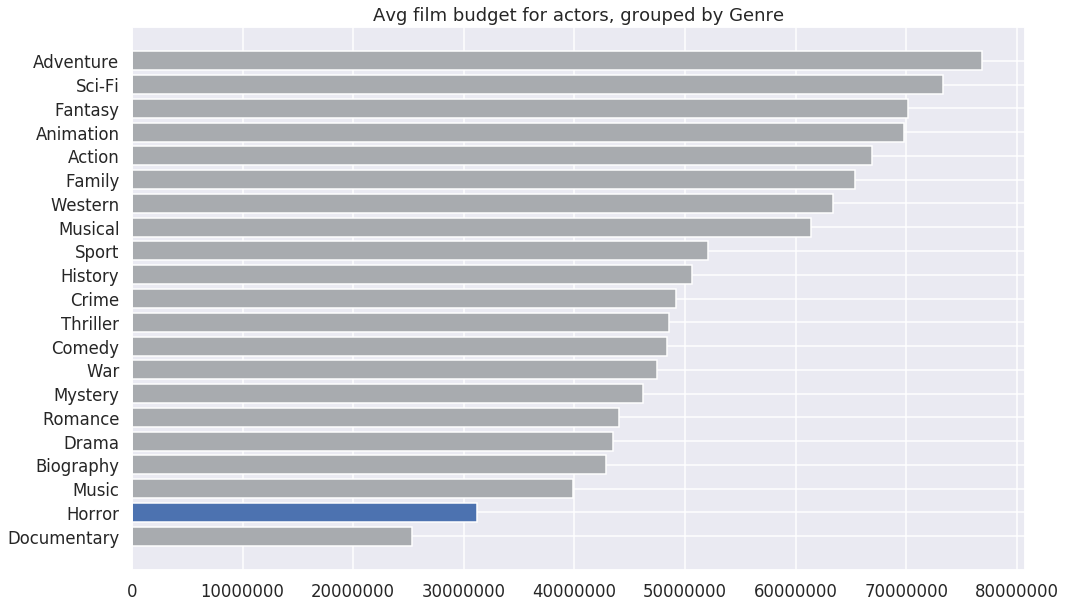

In [53]:
genre_actors_budgets = genre_actors_metrics.avg_budget.sort_values(ascending=True)

plt.figure(figsize=(16,10))


for g in genre_actors_budgets.index:
    if g == 'Horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, genre_actors_budgets[g], color=c)

plt.xticks(rotation=0)
plt.title('Avg film budget for actors, grouped by Genre')
plt.ticklabel_format(axis='x', style='plain')
plt.show()

## Film Ratings

In [54]:
films.rated.unique()

array(['PG-13', 'R', 'N/A', 'PG', 'NOT RATED', 'APPROVED', 'G', 'TV-PG',
       'TV-14', 'NC-17', 'TV-MA', 'UNRATED', 'TV-Y7', 'TV-Y', 'PASSED'],
      dtype=object)

In [55]:
r_rated = films[films.rated == 'R']
r_rated['film_count'] = 1
r_rated_cumsum = r_rated.sort_index().cumsum().film_count

pg13_rated = films[films.rated == 'PG-13']
pg13_rated['film_count'] = 1
pg13_rated_cumsum = pg13_rated.sort_index().cumsum().film_count

pg_rated = films[films.rated == 'PG']
pg_rated['film_count'] = 1
pg_rated_cumsum = pg_rated.sort_index().cumsum().film_count

g_rated = films[films.rated == 'G']
g_rated['film_count'] = 1
g_rated_cumsum = g_rated.sort_index().cumsum().film_count

/home/will/anaconda3/envs/film-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/will/anaconda3/envs/film-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/will/anaconda3/envs/film-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

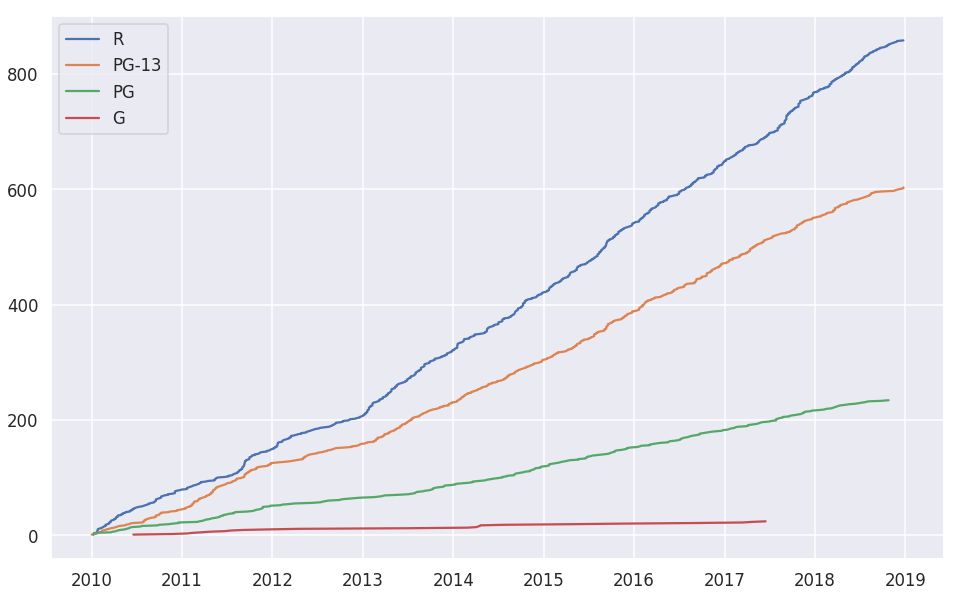

In [56]:
r_rated_cumsum = r_rated.sort_index().cumsum().film_count

plt.figure(figsize=(16,10))
plt.plot(r_rated_cumsum.index, r_rated_cumsum.values, label='R')
plt.plot(pg13_rated_cumsum.index, pg13_rated_cumsum.values, label='PG-13')
plt.plot(pg_rated_cumsum.index, pg_rated_cumsum.values, label='PG')
plt.plot(g_rated_cumsum.index, g_rated_cumsum.values, label='G')
plt.plot()

plt.legend()

In [57]:
r_rated.sum().horror/len(r_rated)

0.1456876456876457

In [58]:
pg13_rated.sum().horror/len(pg13_rated)

0.09950248756218906

# Companies

In [59]:
companies = pd.read_sql_query(scripts.read("companies.sql"), engine)

In [60]:
production = companies[companies.role == 'Production']
distribution = companies[companies.role == 'Distribution']

In [61]:
len(production.company.unique())

2601

In [62]:
top_producers = production.groupby('company').count().sort_values(by='title', ascending=False)[:25]
top_producers = top_producers.sort_values(by='title', ascending=True)

Text(0.5, 1.0, 'Top 25 Producers by # of Films Released')

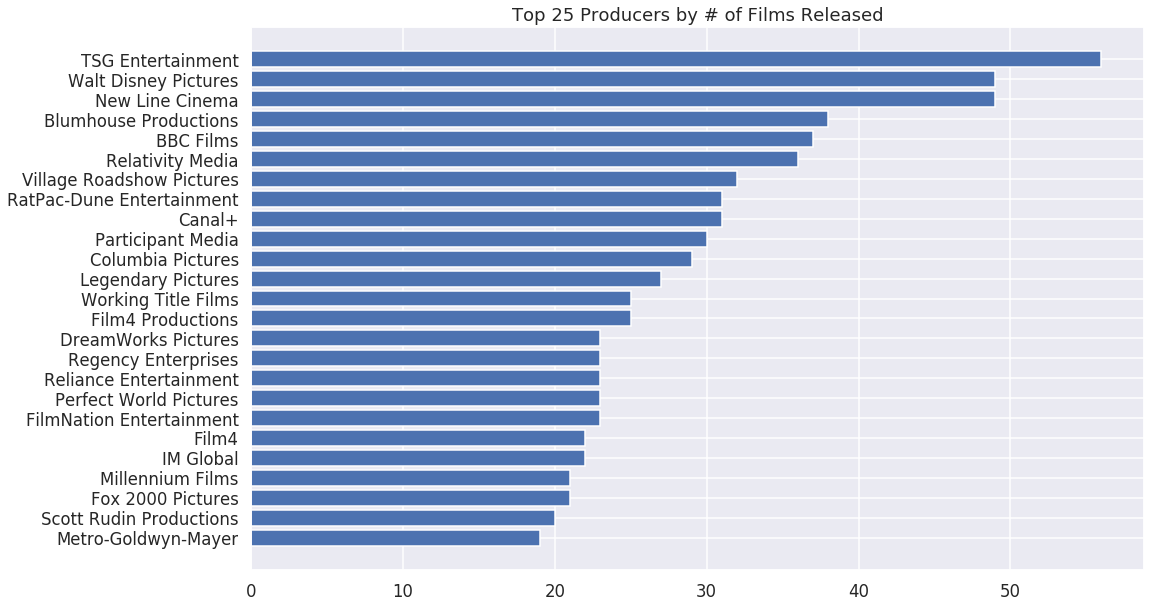

In [63]:
plt.figure(figsize=(16,10))
plt.barh(top_producers.index, top_producers.id)
plt.title('Top 25 Producers by # of Films Released')

In [64]:
top_producers_roi = production.groupby('company').mean().sort_values(by='roi', ascending=False)[3:25]
top_producers_roi = top_producers_roi.sort_values(by='roi', ascending=True)

Text(0.5, 1.0, 'Top 25 Producers by ROI')

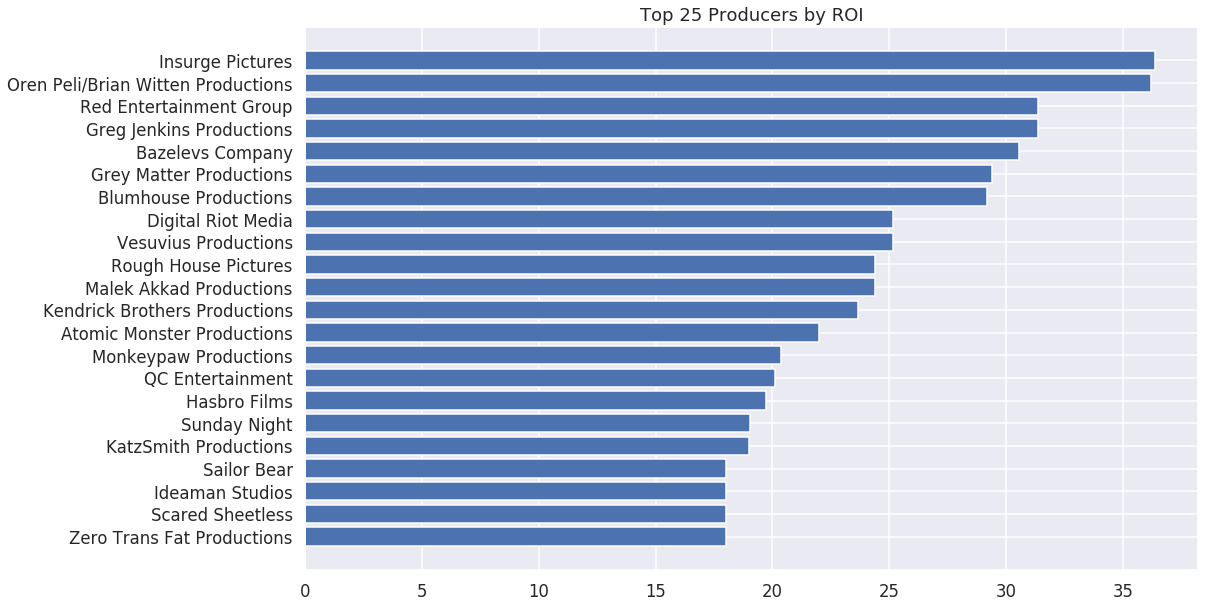

In [65]:
plt.figure(figsize=(16,10))
plt.barh(top_producers_roi.index, top_producers_roi.roi)
plt.title('Top 25 Producers by ROI')

In [66]:
horror_prod = production[production.id.isin(horror_ids)]

In [67]:
len(horror_prod.company.unique())

445

In [68]:
top_horror_prod = horror_prod.groupby('company').count().sort_values(by='title', ascending=False)[:25]
top_horror_prod = top_horror_prod.sort_values(by='company_id', ascending=True)

<BarContainer object of 25 artists>

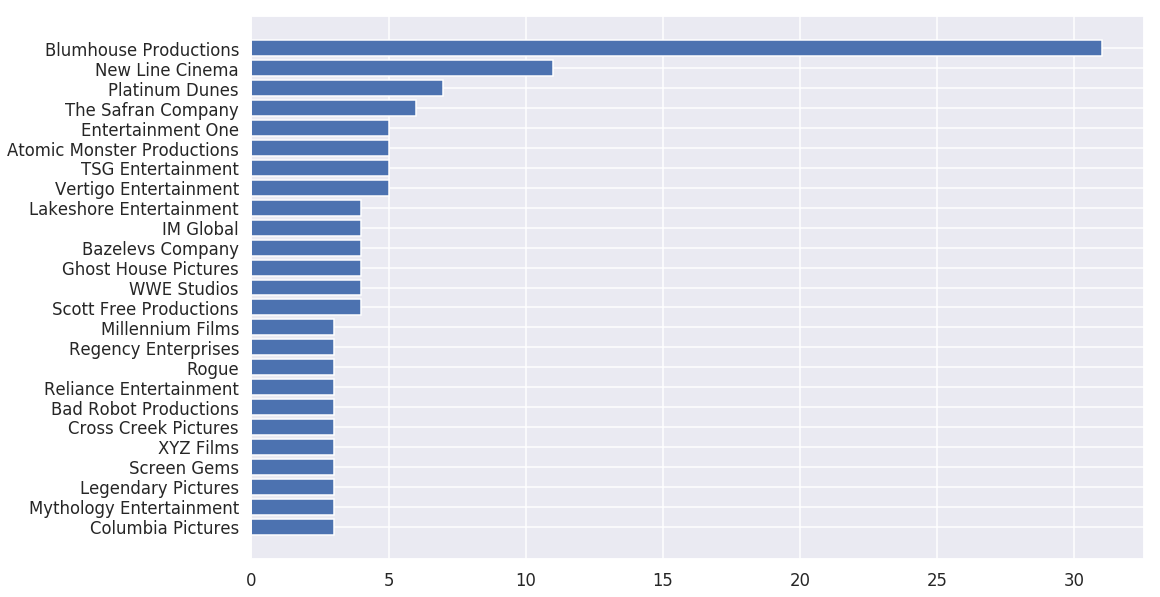

In [69]:
plt.figure(figsize=(16,10))
plt.barh(top_horror_prod.index, top_horror_prod.title)

In [70]:
mean_blumhouse_budget = production.groupby('company').mean().budget['Blumhouse Productions']
mean_film_budget = films.budget.mean()
mean_horror_budget = horror.budget.mean()

In [71]:
mean_blumhouse_budget

7128571.428571428

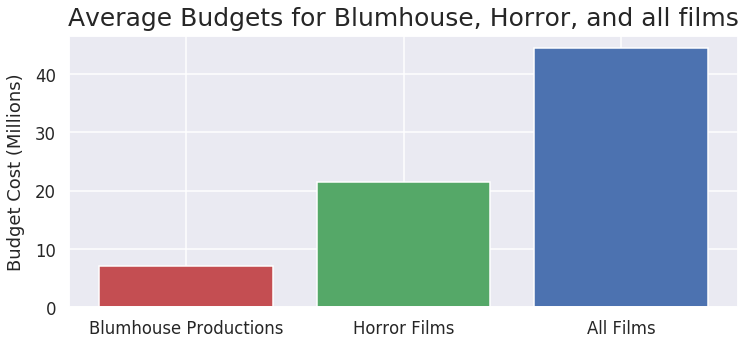

In [78]:
plt.figure(figsize=(12,5))
budget_ix = ['Blumhouse Productions', 'Horror Films', 'All Films']
budget_vals = np.array([mean_blumhouse_budget, mean_horror_budget, mean_film_budget])
plt.bar(budget_ix, budget_vals/1000000, color='rgb')
plt.ticklabel_format(axis='y', style='plain')
plt.title('Average Budgets for Blumhouse, Horror, and all films', fontsize=25, pad=10)
plt.ylabel("Budget Cost (Millions)", labelpad=10)
plt.savefig(save_to_figures("blumhouse_vs_horror_all_films.png"))

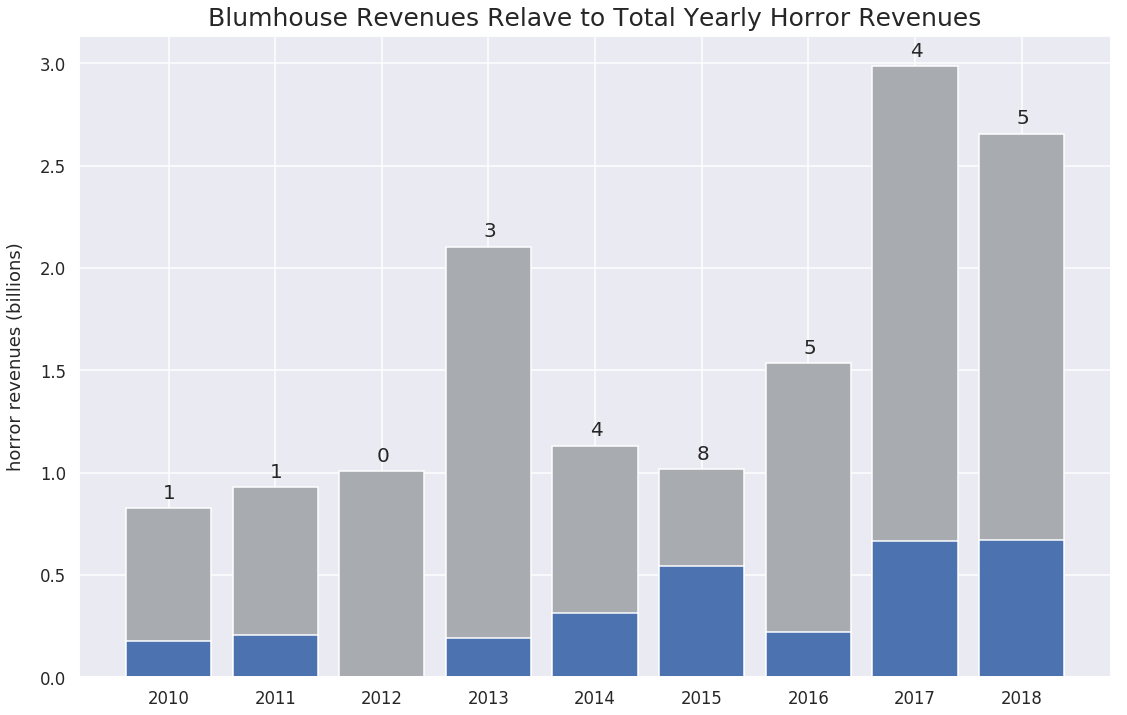

In [81]:
years = films.index.year.unique()
horror_prod = horror_prod.set_index(pd.DatetimeIndex(horror_prod.released))

plt.figure(figsize=(16,10))

for year in years[::-1]:
    horror_grosses_that_year = horror[horror.index.year == year].total_gross.sum()
    horror_prod_that_year = horror_prod[horror_prod.index.year == year]
    try:
        blumhouse_that_year = horror_prod_that_year.groupby('company').sum().\
                              total_gross.loc['Blumhouse Productions']
        blumhouse_count = horror_prod_that_year.groupby('company').count().\
                              id.loc['Blumhouse Productions']
    except KeyError:
        blumhouse_that_year = 0
        blumhouse_count = 0
    #plt.bar(year, blumhouse_that_year/horror_grosses_that_year, color='b')
    plt.bar(year, horror_grosses_that_year/1000000000, color='#a8abaf' )
    plt.bar(year, blumhouse_that_year/1000000000, color='b')
    pct = round(blumhouse_that_year/horror_grosses_that_year, 3)
    plt.annotate(blumhouse_count, (year - 0.05, (horror_grosses_that_year/1000000000) + 0.05), fontsize=20)
    
plt.ylabel("horror revenues (billions)", labelpad=15)
plt.ticklabel_format(axis='y', style='plain')
plt.xticks(years)
plt.tight_layout()
plt.title("Blumhouse Revenues Relave to Total Yearly Horror Revenues", fontsize=25, pad=10)
plt.savefig(save_to_figures("blumhouse_pct_revenues.png"))
plt.show()

In [82]:
from datetime import datetime, timedelta

In [83]:
years = years[::-1]

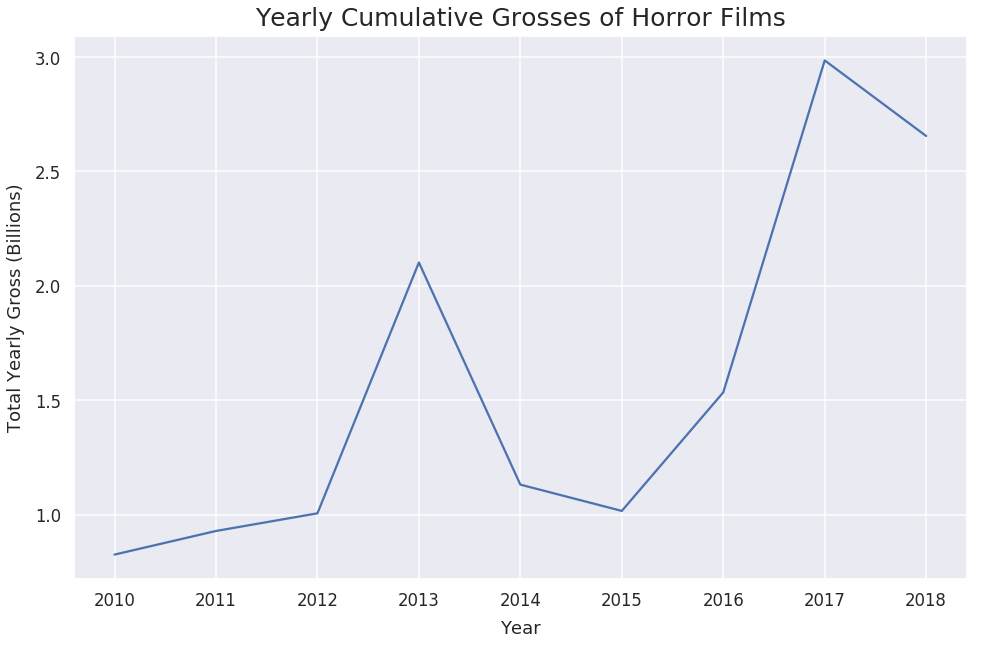

<Figure size 432x288 with 0 Axes>

In [86]:
plt.figure(figsize=(16,10))

horror_yearly_grosses = (horror.resample('Y').sum().total_gross)
horror_yearly_releases = horror.resample('Y').count().id
plt.plot(years, horror_yearly_grosses.values/1000000000) # yearly grosses in billions

#plt.savefig("fig9.png")
plt.ylabel("Total Yearly Gross (Billions)", labelpad=10)
plt.xlabel("Year", labelpad=10)
plt.title("Yearly Cumulative Grosses of Horror Films", fontsize=25, pad=10)
plt.show()

plt.savefig(save_to_figures("yearly_cumulative_horror.png"))

In [88]:
total_yearly_grosses = films.resample('Y').sum().total_gross

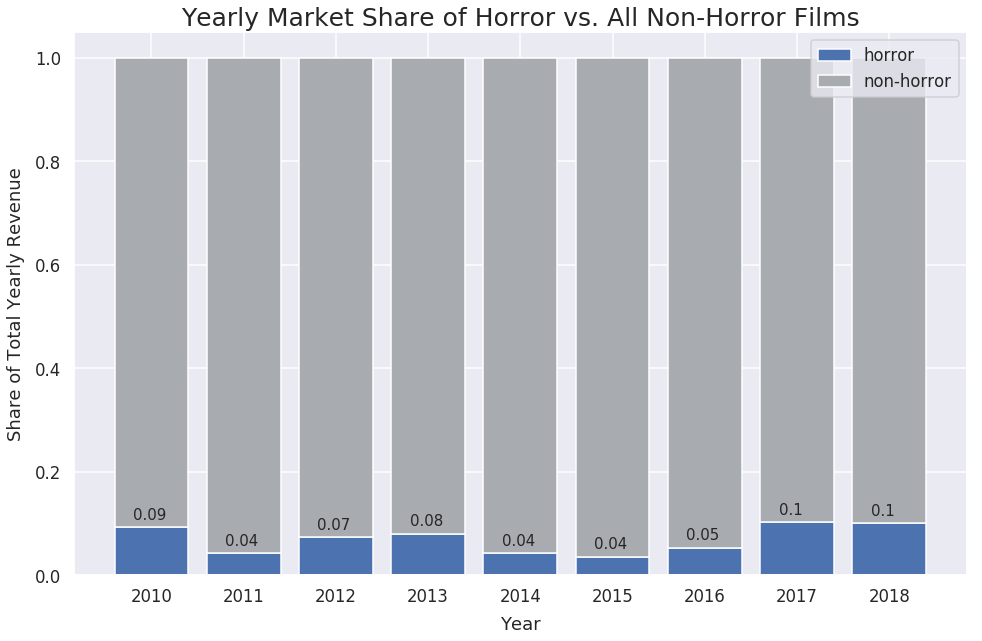

In [91]:
plt.figure(figsize=(16,10))

horror_pct = horror_yearly_grosses.values / total_yearly_grosses.values
non_horror_pct = 1 - horror_pct

y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.bar(horror_yearly_grosses.index.year, horror_pct, label='horror') 
plt.bar(horror_yearly_grosses.index.year, non_horror_pct, bottom=horror_pct, label='non-horror', color='#a8abaf')
#plt.yticks(y_ticks)
plt.xticks(years)

for year, pct in zip(horror_yearly_grosses.index.year, horror_pct):
    plt.annotate(str(round(pct, 2)), (year - 0.2, pct + 0.015), fontsize=15)

plt.legend()
plt.xlabel("Year", labelpad=10)
plt.ylabel("Share of Total Yearly Revenue", labelpad=10)
plt.title("Yearly Market Share of Horror vs. All Non-Horror Films", fontsize=25)

plt.savefig(save_to_figures("yearly_horror_vs_nonhorror_ms.png"))

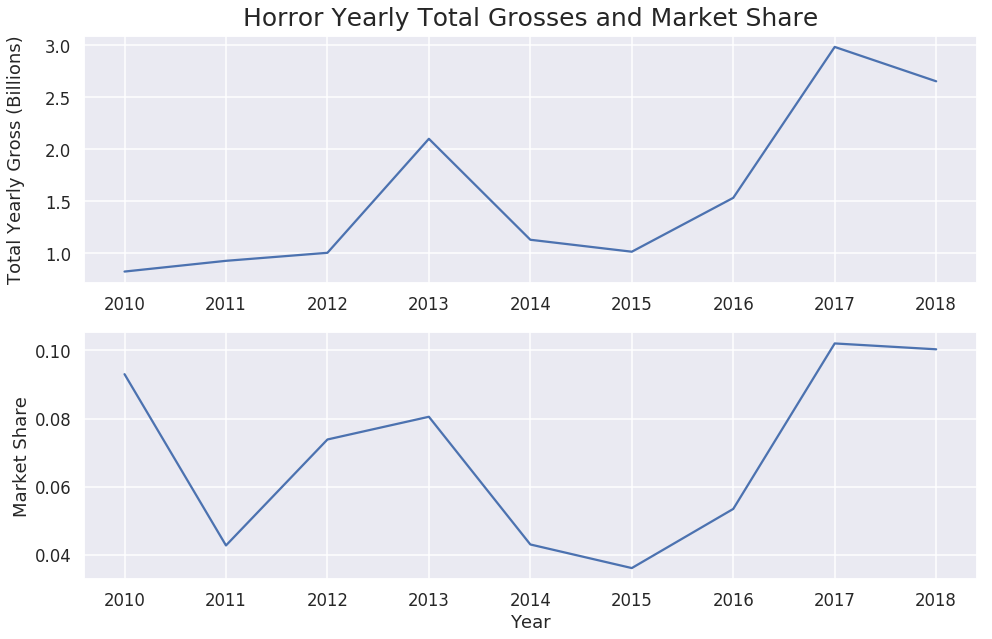

In [93]:
plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.plot(years, horror_yearly_grosses.values/1000000000)
plt.ylabel("Total Yearly Gross (Billions)", labelpad=20)
plt.title("Horror Yearly Total Grosses and Market Share", pad=10, fontsize=25)
plt.xticks(ticks=None)

plt.subplot(2,1,2)
plt.plot(horror_yearly_grosses.index.year, horror_pct)
plt.ylabel("Market Share")
plt.xlabel("Year")

plt.savefig(save_to_figures("horror_yearly_grosses_ms.png"))

In [94]:
horror_pct.mean()

0.06945963935570636

In [95]:
for year in years[::-1]:
    horror_count_that_year = horror[horror.index.year == year].id.count()
    horror_prod_that_year = horror_prod[horror_prod.index.year == year]
    try:
        blumhouse_that_year = horror_prod_that_year.groupby('company').count().\
                              id.loc['Blumhouse Productions']
    except Exception as e:
        pass
    print("{}:{}".format(year, blumhouse_that_year))

2018:5
2017:4
2016:5
2015:8
2014:4
2013:3
2012:3
2011:1
2010:1


Text(0, 0.5, 'Total Gross (Billions)')

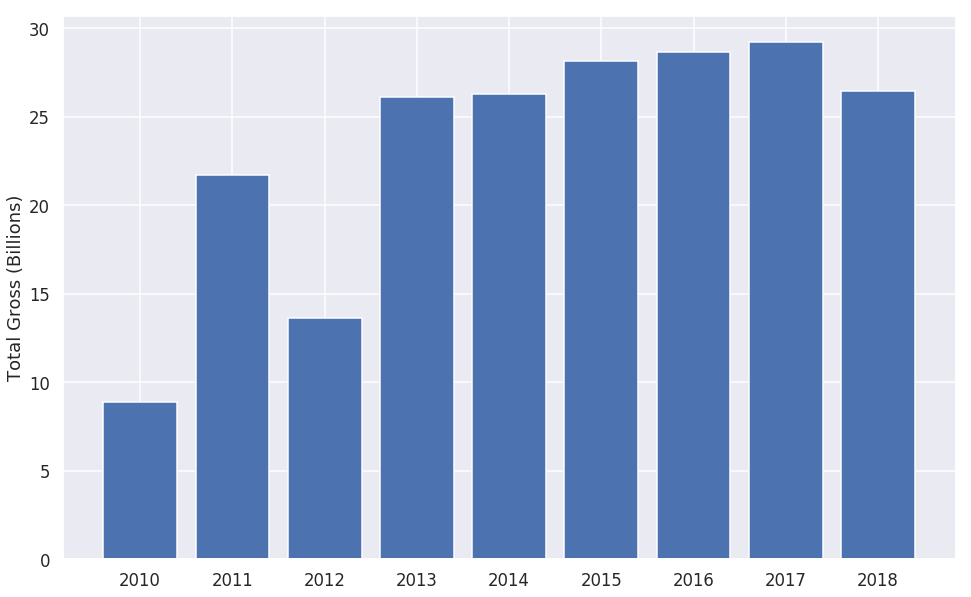

In [96]:
industry_total_gross = films.resample('Y').sum().total_gross

plt.figure(figsize=(16,10))
plt.bar(years, industry_total_gross.values/1000000000)
plt.ticklabel_format(axis='y', style='plain')
plt.xticks(years)
plt.ylabel("Total Gross (Billions)")

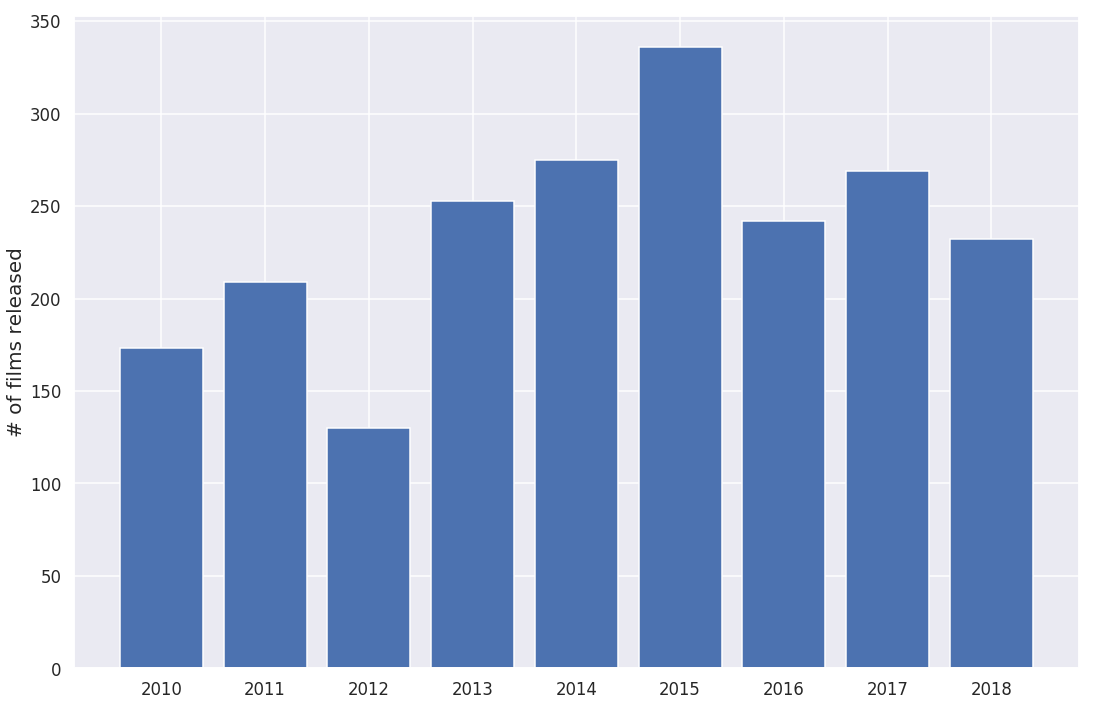

In [98]:
industry_num_releases = films.resample('Y').count().id

plt.figure(figsize=(18,12))
plt.bar(years, industry_num_releases.values)
plt.xticks(years)
plt.ylabel('# of films released', fontsize=20)
#plt.title("Total Films Released per Year", fontsize=30)
plt.savefig('fig1.png')

In [100]:
industry_num_releases.mean()

235.44444444444446

In [101]:
genres

Index(['horror', 'mystery', 'thriller', 'action', 'crime', 'drama', 'comedy',
       'history', 'war', 'music', 'romance', 'sci-fi', 'biography', 'fantasy',
       'animation', 'adventure', 'family', 'sport', 'western', 'documentary',
       'musical'],
      dtype='object')

In [103]:
for g in genres:
    genre_films = films[films[g] == 1]
  
    genre_grosses[g] = genre_films.total_gross.median()

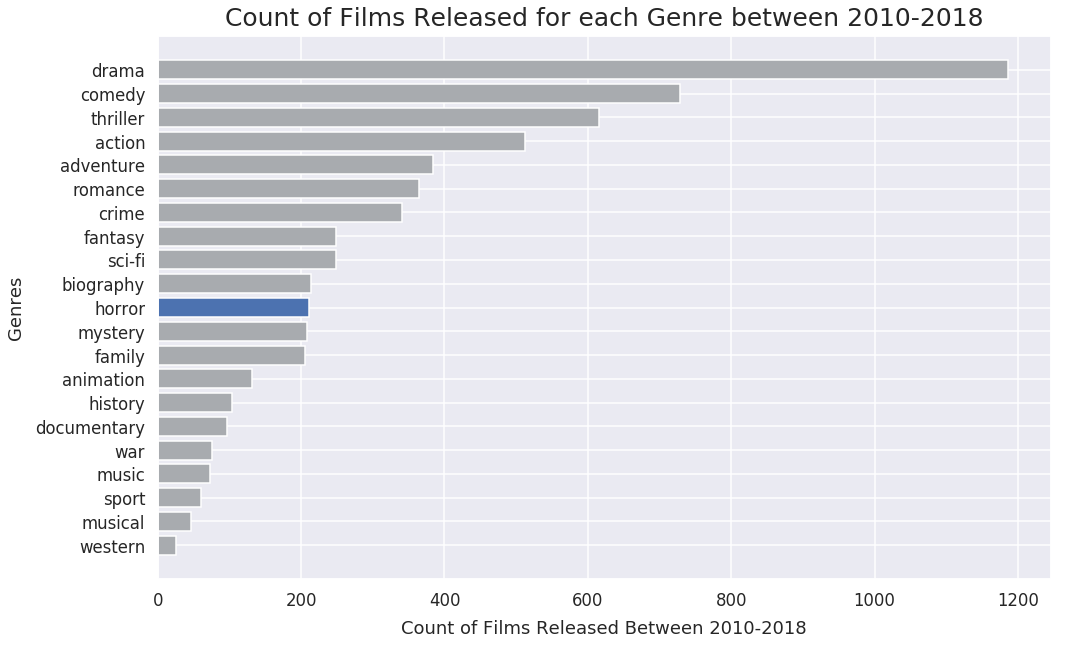

In [107]:
genre_sums = films[genres].sum().sort_values(ascending=True)
plt.figure(figsize=(16,10))
for g in genre_sums.index:
    if g == 'horror':
        c ='b'
    else: c = '#a8abaf'
    plt.barh(g, genre_sums[g], color=c)

plt.ylabel("Genres", labelpad=10)
plt.xlabel("Count of Films Released Between 2010-2018", labelpad=10)
plt.title("Count of Films Released for each Genre between 2010-2018", fontsize=25, pad=10)
plt.savefig(save_to_figures("genre_release_count.png"))

In [108]:
genre_sums

western          25
musical          46
sport            60
music            73
war              76
documentary      96
history         104
animation       131
family          205
mystery         208
horror          211
biography       214
sci-fi          249
fantasy         249
crime           341
romance         365
adventure       384
action          512
thriller        615
comedy          729
drama          1186
dtype: int64

In [109]:
horror.resample('Y').count()

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2010-12-31,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
2011-12-31,15,15,15,15,15,15,15,15,15,14,...,15,15,15,15,15,15,15,15,15,15
2012-12-31,17,17,17,17,17,17,17,17,16,15,...,17,17,17,17,17,17,17,17,17,17
2013-12-31,29,29,29,29,29,29,29,29,29,27,...,29,29,29,29,29,29,29,29,29,29
2014-12-31,21,21,21,21,21,21,21,21,21,20,...,21,21,21,21,21,21,21,21,21,21
2015-12-31,22,22,22,22,22,22,22,22,21,19,...,22,22,22,22,22,22,22,22,22,22
2016-12-31,33,33,33,33,33,33,33,33,32,33,...,33,33,33,33,33,33,33,33,33,33
2017-12-31,35,35,35,35,35,35,35,35,34,33,...,35,35,35,35,35,35,35,35,35,35
2018-12-31,25,25,25,25,25,25,25,25,25,24,...,25,25,25,25,25,25,25,25,25,25


In [110]:
films[genres].corr().horror

horror         1.000000
mystery        0.218709
thriller       0.276969
action        -0.047799
crime         -0.107033
drama         -0.216193
comedy        -0.134664
history       -0.075549
war           -0.047189
music         -0.054173
romance       -0.101613
sci-fi         0.093996
biography     -0.095766
fantasy        0.045055
animation     -0.072277
adventure     -0.095074
family        -0.082175
sport         -0.056767
western       -0.007143
documentary   -0.072442
musical       -0.038722
Name: horror, dtype: float64

In [111]:
df = pd.DataFrame({"horror": films[genres].corr().horror.values[1:]},
                   index=films[genres].corr().horror.index[1:])

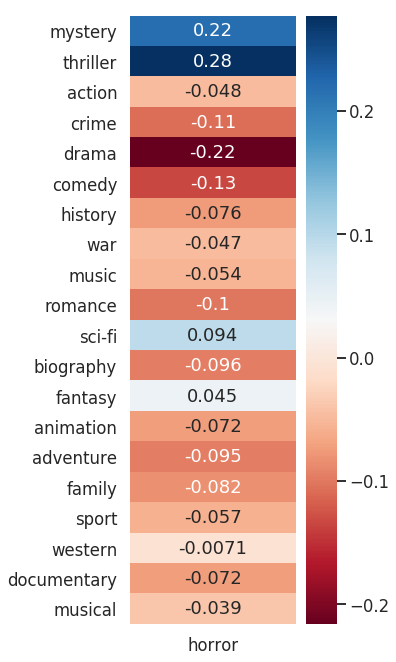

In [114]:
plt.figure(figsize=(6,10))
sns.heatmap(df, annot=True, cmap='RdBu')
plt.margins(x=10, y=10)
plt.tight_layout(pad=2)
plt.savefig(save_to_figures("horror_genre_corr.png"))

In [115]:
horror[genres].sum()

horror         211
mystery         62
thriller       141
action          38
crime            9
drama           50
comedy          32
history          0
war              2
music            1
romance         12
sci-fi          44
biography        3
fantasy         34
animation        2
adventure       15
family           5
sport            0
western          2
documentary      0
musical          1
dtype: int64

In [116]:
horror[horror.comedy == 1]

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2018-09-21,189,The House with a Clock in Its Walls,N/A,0,0,0,0,6.1,67.0,57.0,...,1,0,1,0,0,1,0,0,0,0
2018-10-12,209,Goosebumps 2: Haunted Halloween,N/A,0,0,0,0,5.7,47.0,53.0,...,0,0,1,0,1,1,0,0,0,0
2018-11-30,247,Anna and the Apocalypse,R,0,0,0,0,6.7,77.0,74.0,...,0,0,1,0,0,0,0,0,0,1
2016-04-01,603,Meet the Blacks,R,0,0,0,0,6.0,11.0,26.0,...,0,0,0,0,0,0,0,0,0,0
2016-10-21,734,Boo! A Madea Halloween,PG-13,0,0,0,0,4.6,20.0,30.0,...,0,0,0,0,0,0,0,0,0,0
2015-09-11,1078,The Visit,PG-13,14,0,0,0,6.2,66.0,55.0,...,0,0,0,0,0,0,0,0,0,0
2015-10-16,1121,Goosebumps,PG,0,0,0,0,6.3,76.0,60.0,...,0,0,1,0,1,1,0,0,0,0
2015-10-30,1128,Scouts Guide to the Zombie Apocalypse,R,0,0,0,0,6.3,44.0,32.0,...,0,0,0,0,0,0,0,0,0,0
2015-12-04,1150,Krampus,PG-13,14,0,0,0,6.2,67.0,49.0,...,0,0,1,0,0,0,0,0,0,0


In [119]:
mean_confidence_interval(horror_array)

(6.95766668491648, 5.110754127930825, 8.804579241902134)

In [120]:
mean_confidence_interval(non_horror_array)

(2.327459666376172, 2.104212293004626, 2.5507070397477185)

In [121]:
films.sort_values(by='roi', ascending=False)[['title', 'roi', 'horror']][:20]

,title,roi,horror
released,,,
2015-07-10,The Gallows,429.000000,1
2012-01-06,The Devil Inside,100.800000,1
2018-08-31,Searching,74.400000,0
2015-04-17,Unfriended,63.099999,1
2010-10-22,Paranormal Activity 2,58.166667,1
2017-02-24,Get Out,55.757258,1
2011-10-21,Paranormal Activity 3,40.400000,1
2014-10-03,Annabelle,38.545794,1
2012-05-25,Chernobyl Diaries,36.200000,1


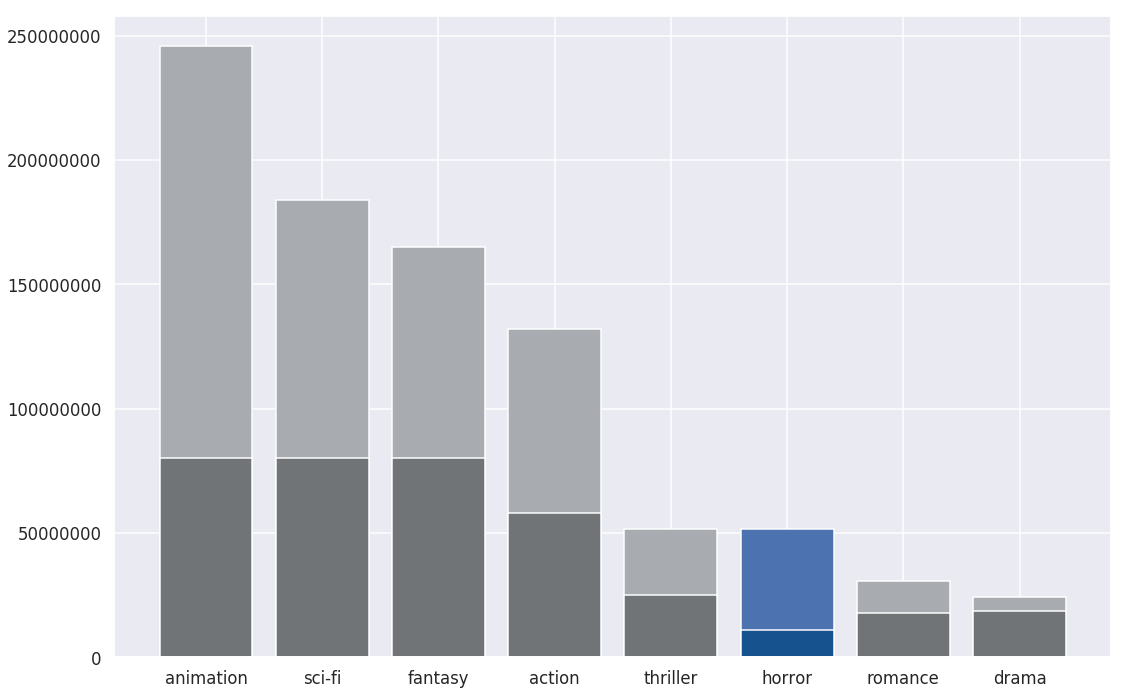

In [123]:
example_genres = ['animation', 'sci-fi', 'fantasy', 'action', 'thriller', 'horror', 'romance', 'drama']
n = np.arange(len(example_genres))
width = 0.3

plt.figure(figsize=(16,10))
for g in example_genres:
    if g == 'horror':
        c1 ='b'
        c2 = '#15528e'
    else:
        c1 = '#a8abaf'
        c2 = '#717477'
    
    plt.bar(g, median_grosses[g], color=c1)
    plt.bar(g, median_budgets[g], color=c2)
        
    #plt.bar(n, median_budgets[g], width=width, color=c)
    #plt.bar(n + width, median_grosses[g], width=width, color=c)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()

In [124]:
for g in example_genres:
    print("{} Budget: {} Grosses: {}".format(g, median_budgets[g], median_grosses[g]))

animation Budget: 80000000.0 Grosses: 245724603.0
sci-fi Budget: 80000000.0 Grosses: 183700000.0
fantasy Budget: 80000000.0 Grosses: 165000000.0
action Budget: 58000000.0 Grosses: 131940411.0
thriller Budget: 25000000.0 Grosses: 51719274.5
horror Budget: 10800000.0 Grosses: 51400000.0
romance Budget: 18000000.0 Grosses: 30600000.0
drama Budget: 18750000.0 Grosses: 24121245.0


In [125]:
pd.set_option('display.max_columns', 50)

films[films.title == 'The Gallows']

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,horror,mystery,thriller,action,crime,drama,comedy,history,war,music,romance,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-10,1005,The Gallows,R,0,0,0,0,4.2,15.0,30.0,100000.0,22764410.0,20200000.0,0.529405,0.469767,43000000.0,429.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [126]:
daily = pd.read_sql_query(scripts.read("mojo_daily.sql"), engine)

In [127]:
len(daily.id.unique())

1455

In [128]:
horror_daily = daily[daily.id.isin(horror_ids)]

In [129]:
horror_daily.head()

,date,id,day,rank,gross,num_theatres,num_day
0,2018-01-05,1,Fri,1.0,12723575,3116,1
1,2018-01-06,1,Sat,2.0,11023230,3116,2
2,2018-01-07,1,Sun,3.0,5834550,3116,3
3,2018-01-08,1,Mon,3.0,1770225,3116,4
4,2018-01-09,1,Tue,3.0,2206025,3116,5


In [134]:
horror_daily = daily[daily.id.isin(horror.sort_values(by="roi", ascending=False).id[:30])]

<Figure size 1152x432 with 0 Axes>

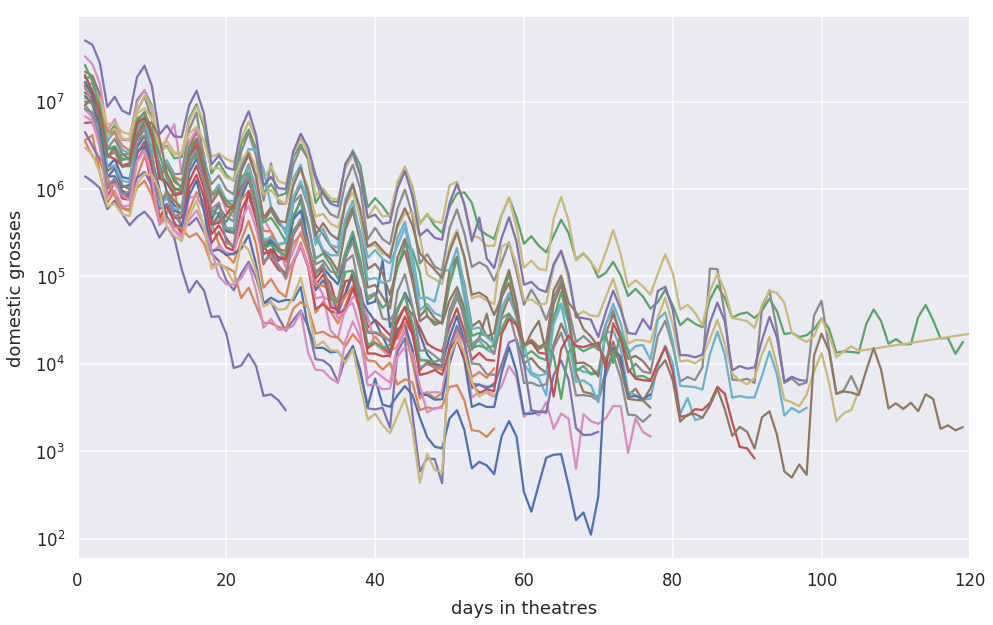

In [135]:
plt.figure(figsize=(16,6))
fig, ax = plt.subplots(figsize=(16,10))

for film_id in horror_daily.id.unique()[:30]:
    film_data = horror_daily[horror_daily.id == film_id]
    release_window = film_data.num_day
    film_gross = film_data.gross
    ax.plot(release_window, film_gross)


# plt.ticklabel_format(axis='y', style='plain')
# plt.xlim((0, 120))
ax.set_xlabel("days in theatres", labelpad=10)
ax.set_ylabel("domestic grosses", labelpad=10)
ax.set_xlim((0, 120))
ax.set_yscale("log")
# plt.tight_layout()

# ax.set_xticks(ind + width / 2)
# ax.set_xticklabels(example_genres)
# plt.title('Median Budgets and Total Grosses for Selected Genres', pad=10, fontsize=25)
# ax.legend()
# ax.set_ylabel('Dollar Value (Millions)', labelpad=15)
# ax.set_xlabel('Genres', labelpad=15)

In [136]:
total_horror_daily = len(horror_daily.id.unique())

In [137]:
past_30 = len(horror_daily[horror_daily.num_day >= 30].id.unique())
past_60 = len(horror_daily[horror_daily.num_day >= 60].id.unique())
past_90 = len(horror_daily[horror_daily.num_day >= 90].id.unique())

In [138]:
for i in [past_30, past_60, past_90]:
    print(i/total_horror_daily)

0.9655172413793104
0.6206896551724138
0.27586206896551724


In [139]:
films.head()

,id,title,rated,award_noms,award_wins,oscar_noms,oscar_wins,ratings_imdb,ratings_tomatoes,ratings_meta,budget,domestic_gross,foreign_gross,domestic_pct,foreign_pct,total_gross,roi,horror,mystery,thriller,action,crime,drama,comedy,history,war,music,romance,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-05,1,Insidious: The Last Key,PG-13,0,0,0,0,5.7,32.0,49.0,10000000.0,67745330.0,100140258.0,0.403521,0.596479,167885588.0,15.788559,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-12,5,The Commuter,PG-13,0,0,0,0,6.3,57.0,56.0,40000000.0,36343858.0,83598529.0,0.180905,0.416120,200900000.0,4.022500,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-12,6,Proud Mary,R,0,0,0,0,4.9,28.0,35.0,14000000.0,20877013.0,876352.0,0.957661,0.040200,21800000.0,0.557143,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-12,8,Freak Show,N/A,0,0,0,0,6.3,51.0,54.0,2000000.0,18216.0,0.0,1.000000,0.000000,18216.0,-0.990892,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-19,12,12 Strong,R,0,0,0,0,6.6,52.0,54.0,35000000.0,45819713.0,21631102.0,0.647171,0.305524,70800000.0,1.022857,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
ratings_dict = dict()

for g in genres:
    films_in_that_genre = films[films[g] == 1]
    
    mean_tomatoes = films_in_that_genre.ratings_tomatoes.mean()
    mean_meta = films_in_that_genre.ratings_meta.mean()
    mean_imdb = films_in_that_genre.ratings_imdb.mean()
    
    mean_budget = films_in_that_genre.budget.mean()
    mean_gross = films_in_that_genre.total_gross.mean()
    mean_roi = films_in_that_genre.roi.mean()
    
    ratings_dict[g] = [mean_tomatoes, mean_meta, mean_imdb,
                       mean_budget, mean_gross, mean_roi]

ratings_financials = pd.DataFrame.from_dict(ratings_dict, orient='index')
ratings_financials.columns = ['tomatoes_avg', 'meta_avg', 'imdb_avg',
                         'budget_avg', 'total_gross_avg', 'roi_avg']
ratings_financials['imdb_avg'] = ratings_financials['imdb_avg'] * 10

In [141]:
ratings_financials

,tomatoes_avg,meta_avg,imdb_avg,budget_avg,total_gross_avg,roi_avg
horror,49.454106,49.030151,57.876777,2.151118e+07,8.493619e+07,10.374121
mystery,54.564767,54.223350,63.830918,3.163436e+07,9.783874e+07,4.920849
thriller,53.099467,52.673835,62.682410,3.860826e+07,1.193667e+08,4.408312
action,50.709052,50.428256,63.502935,7.970160e+07,2.561508e+08,2.091990
crime,54.522152,53.977707,64.510264,3.437102e+07,9.152278e+07,1.507728
drama,62.596100,59.438086,65.965372,2.751144e+07,6.639157e+07,2.320862
comedy,55.649408,54.000000,62.522634,4.263318e+07,1.319658e+08,2.428692
history,65.893617,63.239583,69.057692,3.486618e+07,6.768926e+07,1.399883
war,66.537313,61.462687,68.289474,3.624348e+07,9.101297e+07,1.558070
music,64.597015,59.328358,65.616438,2.800370e+07,1.036273e+08,3.045059


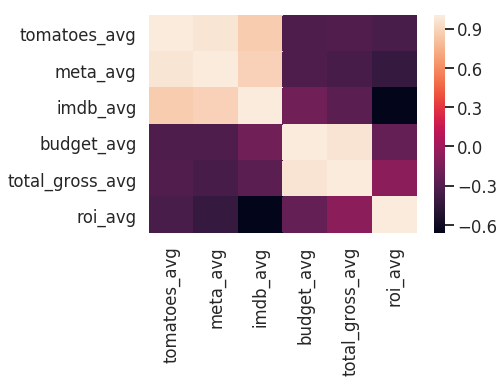

In [142]:
sns.heatmap(ratings_financials.corr())

In [143]:
ratings_financials['imdb_meta_delta'] = ratings_financials.imdb_avg - ratings_financials.meta_avg

In [144]:
ratings_financials

,tomatoes_avg,meta_avg,imdb_avg,budget_avg,total_gross_avg,roi_avg,imdb_meta_delta
horror,49.454106,49.030151,57.876777,2.151118e+07,8.493619e+07,10.374121,8.846626
mystery,54.564767,54.223350,63.830918,3.163436e+07,9.783874e+07,4.920849,9.607568
thriller,53.099467,52.673835,62.682410,3.860826e+07,1.193667e+08,4.408312,10.008575
action,50.709052,50.428256,63.502935,7.970160e+07,2.561508e+08,2.091990,13.074679
crime,54.522152,53.977707,64.510264,3.437102e+07,9.152278e+07,1.507728,10.532557
drama,62.596100,59.438086,65.965372,2.751144e+07,6.639157e+07,2.320862,6.527285
comedy,55.649408,54.000000,62.522634,4.263318e+07,1.319658e+08,2.428692,8.522634
history,65.893617,63.239583,69.057692,3.486618e+07,6.768926e+07,1.399883,5.818109
war,66.537313,61.462687,68.289474,3.624348e+07,9.101297e+07,1.558070,6.826787
music,64.597015,59.328358,65.616438,2.800370e+07,1.036273e+08,3.045059,6.288080


In [145]:
horror.ratings_imdb.mean()

5.787677725118482

In [146]:
non_horror.ratings_imdb.mean()

6.491701680672269

In [147]:
horror.ratings_imdb.mean()

5.787677725118482

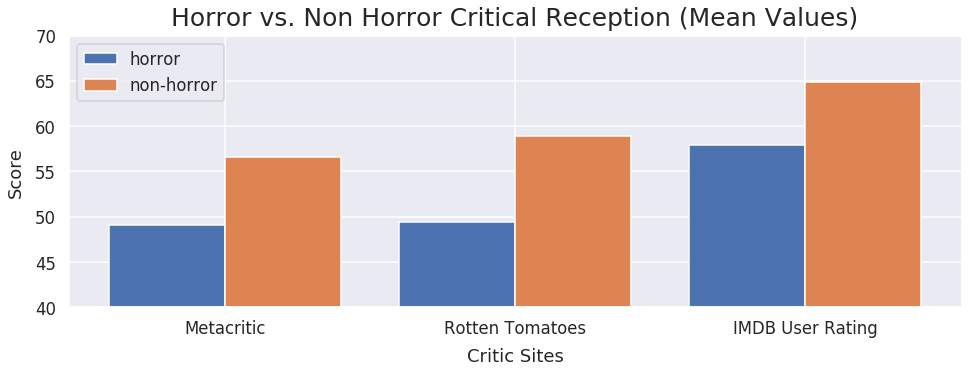

In [150]:
fig, ax = plt.subplots(figsize=(16,5))

horror_mean_ratings = [horror.ratings_meta.mean(),
                       horror.ratings_tomatoes.mean(),
                       horror.ratings_imdb.mean()* 10]

non_horror_mean_ratings = [non_horror.ratings_meta.mean(),
                           non_horror.ratings_tomatoes.mean(),
                           non_horror.ratings_imdb.mean() * 10]

ind = np.arange(3)
width = 0.4

p1 = ax.bar(ind, horror_mean_ratings, width=width, label='horror')
p2 = ax.bar(ind + width, non_horror_mean_ratings, width=width, label='non-horror')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(["Metacritic", "Rotten Tomatoes", "IMDB User Rating"])
ax.legend()
ax.set_ylabel("Score", labelpad=10)
ax.set_xlabel("Critic Sites", labelpad=10)
ax.set_ylim((40,70))

plt.title("Horror vs. Non Horror Critical Reception (Mean Values)", pad=10, fontsize=25)

plt.savefig(save_to_figures("horror_vs_nonhorror_reception.png"))